### Workflow to get the trial and fixation tables
1. Run ProcessMonkeyGameSingleSubject in Matlab on the TrialSubject Folder from the Experiment
2. Run the Replay app on the file in the ProcessedData Folder
3. Run the Replay script in Matlab on the Replayer generated file
4. Save FixationDetailsForAnalysis and TrialData as structs
5. Load the two .mat files into Python using the custom loadmat script

### Notes/References

http://stackoverflow.com/questions/15512560/access-mat-file-containing-matlab-classes-in-python

http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas

http://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/

### Loading Libraries

In [1]:
import scipy.io as sio
import pandas as pd
import tables
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import math
%matplotlib inline

### Custom Functions for loading matlab structs

In [2]:
# http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], sio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, sio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

### Setting Jupyter Notebook settings and Misc Variables

In [3]:
#pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 50)
directory = './ProcessedStructsForPython/'

### Data Preprocessing
Mostly going through the matlab files

In [4]:
em_list = []
em_copy = []
for _folder in os.listdir(directory): # go through all the files in the directory
    if os.path.isdir(directory+_folder): # if the file is a directory do this
        em_sub_list = []
        for _file in os.listdir(directory+_folder): # go through all the files in the current subject directory
            if _file.find('EM') + 1:
                e = loadmat(directory+_folder+'/'+_file)
                mdata = e['e']
                e = []
                for i in mdata['data']:
                    s = pd.Series(i)
                    e.append(s.to_frame())
                    
                em_df = pd.concat(e, axis=1)
                em_df.columns = mdata['varnames']
                
                em_sub_list.append(em_df)
                
                em_copy.append(em_df)
                
        em = pd.concat(em_sub_list).reset_index()
        em_list.append(em)
for i in range(0, len(em_list)):  
    em_list[i]['block'] = em_list[i]['block'].apply(int)
#         if len(em_sub_list) > 0:
#             em = pd.concat(em_sub_list).reset_index()
#         else:
#             em = pd.DataFrame([])
#         em_list.append(em)

In [5]:
trials_list = []
for _folder in os.listdir(directory): # go through all the files in the directory
    if os.path.isdir(directory+_folder): # if the file is a directory do this
        for _file in os.listdir(directory+_folder): # go through all the files in the current subject directory
             if _file.find('Trials') + 1:
                t = loadmat(directory+_folder+'/'+_file)
                mdata = t['t']
                l = []
                for i in mdata['data']:
                    s = pd.Series(i)
                    l.append(s.to_frame())
                    
                trials_df = pd.concat(l, axis=1)
                trials_df.columns = mdata['varnames']
               
                trials_list.append(trials_df)
for j in range(len(trials_list)):
    trials_list[j]['Acc EM'] = em_list[j]['pmode1']

In [6]:
fixations_list = []
matrix_list = []
for _folder in os.listdir(directory): # go through all the files in the directory
    if os.path.isdir(directory+_folder): # if the file is a directory do this
        for _file in os.listdir(directory+_folder): # go through all the files in the current subject directory
            if _file.find('Fixation') + 1:
                f = loadmat(directory+_folder+'/'+_file)
                mdata = f['f']
                l = []
                for i in mdata['data']:
                    s = pd.Series(i)
                    l.append(s.to_frame())
                fixations_df = pd.concat(l, axis=1)
                fixations_df.columns = mdata['varnames']
                fixations_list.append(fixations_df)
                
for i in range(len(fixations_list)):
    fixations_list[i] = fixations_list[i][pd.notnull(fixations_list[i]['Block'])]
    fixations_list[i]['Block'] = fixations_list[i]['Block'].astype(int)
    fixations_list[i]['TrialInBlock'] = fixations_list[i]['TrialInBlock'].astype(int)
    fixations_list[i]['TrialInExperiment'] = fixations_list[i]['TrialInExperiment'].astype(int)
    fixations_list[i]['FixCategory'] = fixations_list[i]['FixCategory'].astype(int)
    fixations_list[i]['PrePickup'] = fixations_list[i]['PrePickup'].astype(int)
    fixations_list[i]['Epoch'] = fixations_list[i]['Epoch'].astype(int)
    
    fixations_list[i] = fixations_list[i].loc[fixations_list[i]['PrePickup'] == 1] 
    fixations_list[i] = fixations_list[i].loc[fixations_list[i]['Epoch'] == 2] # 2 is from fixation door opens to reward door

    df = fixations_list[i]
    fixation_count = df['Duration'].groupby([df['Block'], df['TrialInBlock'], df['FixCategory']]).count().unstack()
    fixation_count.reset_index(inplace=True)
    fixation_dur = df['Duration'].groupby([df['Block'], df['TrialInBlock'], df['FixCategory']]).mean().unstack()
    fixation_dur.reset_index(inplace=True)
    
    columns = []
    for i in fixation_count.columns:
        if type(i) == int:
            if len(str(i)) == 1:
                name = 'FixCat ' + '0' + str(i) + ' Count'
                if '01' in name:
                    name = 'Target Count'
                if '02' in name:
                    name = 'Distractor Count'
                columns.append(name)
            else:
                columns.append('FixCat ' + str(i) + ' Count')
        elif i == 'TrialInBlock':
            columns.append("Block's Trial")
        else:
            columns.append(i)
    fixation_count.columns = columns
    
    columns = []
    for i in fixation_dur.columns:
        if type(i) == int:
            if len(str(i)) == 1:
                name = 'FixCat ' + '0' + str(i) + ' Duration'
                if '01' in name:
                    name = 'Target Duration'
                if '02' in name:
                    name = 'Distractor Duration'
                columns.append(name)
            else:
                columns.append('FixCat ' + str(i) + ' Duration')
        elif i == 'TrialInBlock':
            columns.append("Block's Trial")
        else:
            columns.append(i)
    fixation_dur.columns = columns
    
    matrix = fixation_dur.add(fixation_count[list(np.arange(2,  len(fixation_count.columns)))], axis=1, fill_value=0)
    matrix = matrix[['Block', "Block's Trial", 'Target Count', 'Target Duration', 'Distractor Count', 'Distractor Duration']]
    matrix_list.append(matrix)
    
data = pd.DataFrame({"Block": 5.0, "Block's Trial": 12.0, 'Target Count': np.nan, 'Target Duration': np.nan, 'Distractor Count': np.nan, 'Distractor Duration': np.nan}, index=[100])
matrix_list[1] = pd.concat([matrix_list[1].ix[:99], data, matrix_list[1].ix[100:]])
data = pd.DataFrame({"Block": 7.0, "Block's Trial": 80.0, 'Target Count': np.nan, 'Target Duration': np.nan, 'Distractor Count': np.nan, 'Distractor Duration': np.nan}, index=[194])
matrix_list[1] = pd.concat([matrix_list[1].ix[:193], data, matrix_list[1].ix[194:]])
trials_list[6] = trials_list[6].ix[:323]
matrix_list[6] = matrix_list[6].ix[:323]
data = pd.DataFrame({"Block": 9.0, "Block's Trial": 18.0, 'Target Count': np.nan, 'Target Duration': np.nan, 'Distractor Count': np.nan, 'Distractor Duration': np.nan}, index=[156])
matrix_list[7] = pd.concat([matrix_list[7].ix[:155], data, matrix_list[7].ix[156:]])
data = pd.DataFrame({"Block": 11.0, "Block's Trial": 49.0, 'Target Count': np.nan, 'Target Duration': np.nan, 'Distractor Count': np.nan, 'Distractor Duration': np.nan}, index=[205])
matrix_list[7] = pd.concat([matrix_list[7].ix[:204], data, matrix_list[7].ix[205:]])

/Users/chensteven/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chensteven/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chensteven/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

In [7]:
# trials_list[7].loc[trials_list[7]['Block'] == 11]
# matrix_list[7].loc[matrix_list[7]['Block'] == 11]
for k in range(0, len(trials_list)):
    print "Subject" + str(k+1) + "\n"
    l = max(em_list[k]['block'].unique())
    for i in range(1, int(l)+2, 2):
        print ("block "+ str(i), len(em_list[k].loc[em_list[k]['block'] == i]))
        print ("Block " + str(i), len(trials_list[k].loc[trials_list[k]['Block'] == i]))

Subject1

('block 1', 22)
('Block 1', 22)
('block 3', 25)
('Block 3', 25)
('block 5', 24)
('Block 5', 24)
('block 7', 29)
('Block 7', 29)
('block 9', 20)
('Block 9', 20)
('block 11', 17)
('Block 11', 17)
('block 13', 17)
('Block 13', 17)
('block 15', 30)
('Block 15', 30)
('block 17', 35)
('Block 17', 35)
Subject2

('block 1', 34)
('Block 1', 34)
('block 3', 56)
('Block 3', 56)
('block 5', 26)
('Block 5', 26)
('block 7', 85)
('Block 7', 85)
Subject3

('block 1', 17)
('Block 1', 17)
('block 3', 17)
('Block 3', 17)
('block 5', 24)
('Block 5', 24)
('block 7', 27)
('Block 7', 27)
('block 9', 29)
('Block 9', 29)
('block 11', 47)
('Block 11', 47)
('block 13', 17)
('Block 13', 17)
('block 15', 17)
('Block 15', 17)
('block 17', 39)
('Block 17', 39)
Subject4

('block 1', 27)
('Block 1', 27)
('block 3', 37)
('Block 3', 37)
('block 5', 30)
('Block 5', 30)
('block 7', 17)
('Block 7', 17)
('block 9', 17)
('Block 9', 17)
('block 11', 22)
('Block 11', 22)
('block 13', 28)
('Block 13', 28)
Subject5

('

In [ ]:
for k in range(0, len(trials_list)):
    print 'Subject' + str(k+1)
    print len(em_list[k])
    print len(trials_list[k])
    print len(matrix_list[k])

### EM

In [8]:
sa_df = []
csa_df = []

for i in range(len(trials_list)):
    smoothAcc = trials_list[i].groupby('TrialInBlock').mean().head(18)['SmoothAcc']
    smoothAcc = smoothAcc.reset_index().astype(float)
    del smoothAcc['TrialInBlock']
    sa_df.append(smoothAcc)
    
for i in range(len(trials_list)):
    trials_list[i]['CombinedSmoothAcc'] = trials_list[i][['SmoothAccContext1', 'SmoothAccContext2']].sum(axis=1)
    smoothAcc = trials_list[i].groupby('TrialInBlock').mean().head(18)['CombinedSmoothAcc']
    smoothAcc = smoothAcc.reset_index().astype(float)
    del smoothAcc['TrialInBlock']
    csa_df.append(smoothAcc)
    
for i in range(len(em_copy)):
    em_copy[i] = em_copy[i].head(18).reset_index()

em = pd.concat(em_copy)
em_average = []
em_std = []
em_var = []

for i in em['subject'].unique():
    em_average.append(em[em['subject'] == i].groupby('index').mean())
    em_std.append(em[em['subject'] == i].groupby('index').std()/ math.sqrt(len(matrix_list)))

for i in range(len(em_average)):
    em_average[i]['smooth'] = sa_df[i]['SmoothAcc']

# overall
sa_overall = pd.concat(sa_df)
csa_overall = pd.concat(csa_df)
em_overall = pd.concat(em_average)

csa_final = csa_overall.reset_index().groupby('index').mean()
csa_error = csa_overall.reset_index().groupby('index').std() / math.sqrt(len(matrix_list))
sa_final = sa_overall.reset_index().groupby('index').mean()
sa_error = sa_overall.reset_index().groupby('index').std() / math.sqrt(len(matrix_list))
em_final = em_overall.reset_index().groupby('index').mean()
em_error = em_overall.reset_index().groupby('index').std() / math.sqrt(len(matrix_list))

fm_list = []

for i in range(0, len(matrix_list)):
    matrix_list[i]['Acc Smoothed'] = trials_list[i]['SmoothAcc']
    matrix_list[i]['Acc Smoothed Combined'] = trials_list[i]['CombinedSmoothAcc']
    if len(em_list[i]) > 0:
        matrix_list[i]['Acc EM'] = em_list[i]['pmode1']
    matrix_list[i]['Beta 0 (Intercept)'] = [0.5] * len(matrix_list[i])
    matrix = matrix_list[i]
    matrix = matrix.reindex_axis(sorted(matrix.columns), axis=1)
    matrix = matrix[list(matrix.columns[:10])]
    #matrix = matrix.dropna()
    fm_list.append(matrix)

### EM Curves

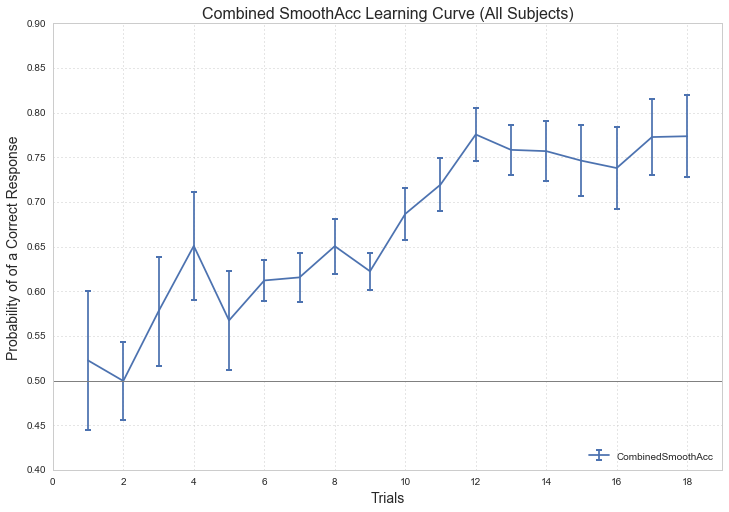

In [9]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    trials = range(1, len(csa_final)+1)
    #errorfill(trials, csa_final['CombinedSmoothAcc'], yerr=csa_error['CombinedSmoothAcc'], ax=ax)
    ax.errorbar(trials, csa_final['CombinedSmoothAcc'], yerr=csa_error['CombinedSmoothAcc'], capthick=2)
    #ax.errorbar(trials, csa_final['CombinedSmoothAcc'], yerr=csa_var['CombinedSmoothAcc'], capthick=2)
    #ax.plot(trials, csa_final['CombinedSmoothAcc'])
    ax.set_xlim(0, len(csa_final)+1)
    ax.set_xticks(np.arange(0, len(csa_final)+1, 2))
    ax.set_ylim(0.4, 0.9)
    ax.set_yticks(np.arange(0.4, 0.95, 0.05))
    ax.axhline(y=0.5, color='gray', lw='1')
    ax.set_title('Combined SmoothAcc Learning Curve (All Subjects)', fontsize=16)
    ax.set_xlabel('Trials', fontsize=14)
    ax.set_ylabel('Probability of of a Correct Response', fontsize=14)
    # plt.tight_layout()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc=4)
    ax.grid(linestyle='dotted')
    plt.show()

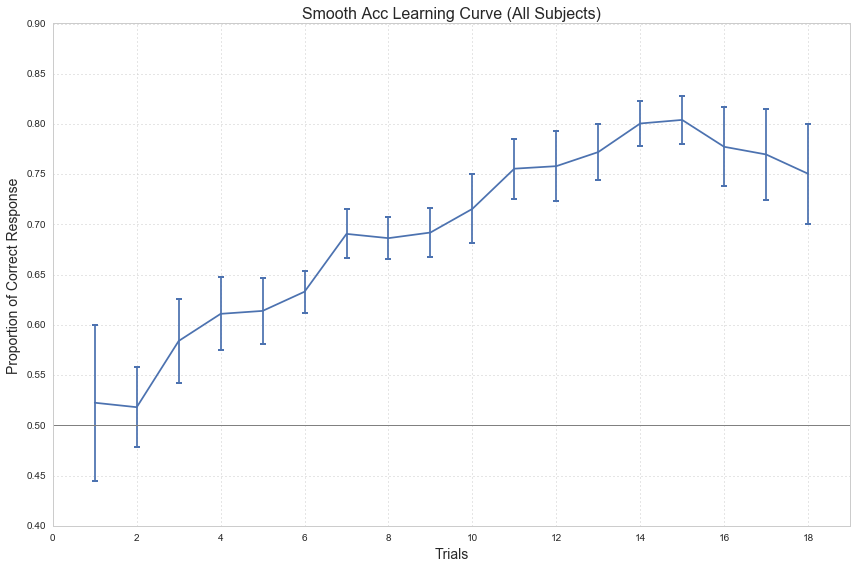

In [11]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    trials = range(1, len(sa_final)+1)
    ax.errorbar(trials, sa_final['SmoothAcc'], yerr=sa_error['SmoothAcc'], capthick=2)
    #ax.plot(trials, sa_final['SmoothAcc'])
    ax.set_xlim(0, len(sa_final)+1)
    ax.set_xticks(np.arange(0, len(sa_final)+1, 2))
    ax.set_ylim(0.4, 0.9)
    ax.set_yticks(np.arange(0.4, 0.95, 0.05))
    ax.axhline(y=0.5, color='gray', lw='1')
    ax.set_title('Smooth Acc Learning Curve (All Subjects)', fontsize=16)
    ax.set_xlabel('Trials', fontsize=14)
    ax.set_ylabel('Proportion of Correct Response', fontsize=14)
    plt.tight_layout()
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles, labels, loc=4)
    ax.grid(linestyle='dotted')
    plt.show()
    fig.savefig('Smooth Acc Learning Curve (All Subjects).png', dpi=300)

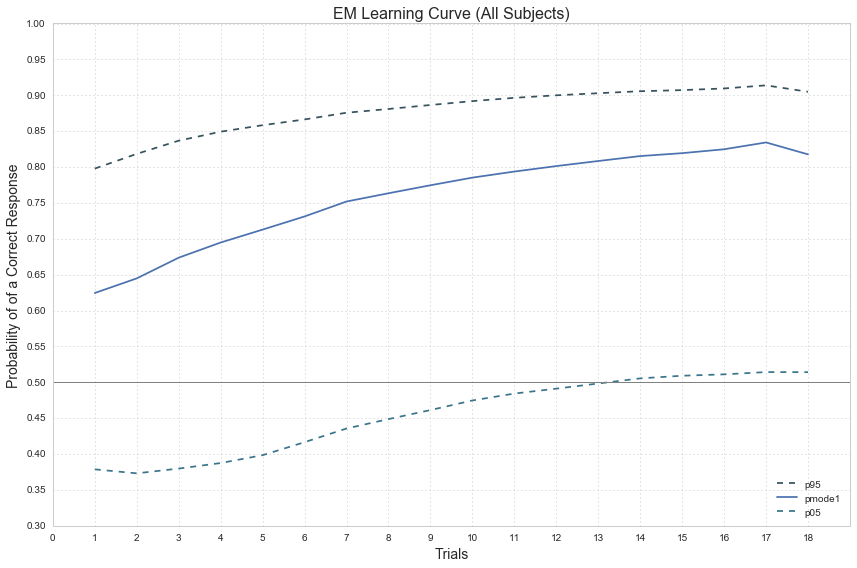

In [81]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    trials = range(1, len(em_final)+1)
    ax.plot(trials, em_final['p95'], ls='dashed', color=sns.color_palette('GnBu_d')[0])
    ax.plot(trials, em_final['pmode1'])
    #ax.errorbar(trials, em_final['pmode1'], yerr=em_error['pmode1'], barsabove=True, capthick=2)
    ax.plot(trials, em_final['p05'], ls='dashed', color=sns.color_palette('GnBu_d')[1])
    ax.set_xlim(0, len(em_final)+1)
    ax.set_xticks(np.arange(0, len(em_final)+1, 1))
    ax.set_ylim(0.3, 1.0)
    ax.set_yticks(np.arange(0.3, 1.05, 0.05))
    ax.axhline(y=0.5, color='gray', lw='1')
    ax.set_title('EM Learning Curve (All Subjects)', fontsize=16)
    ax.set_xlabel('Trials', fontsize=14)
    ax.set_ylabel('Probability of of a Correct Response', fontsize=14)
    plt.tight_layout()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc=4)
    ax.grid(linestyle='dotted')
    plt.show()
    fig.savefig('EM Learning Curve (All Subjects).png', dpi=300)

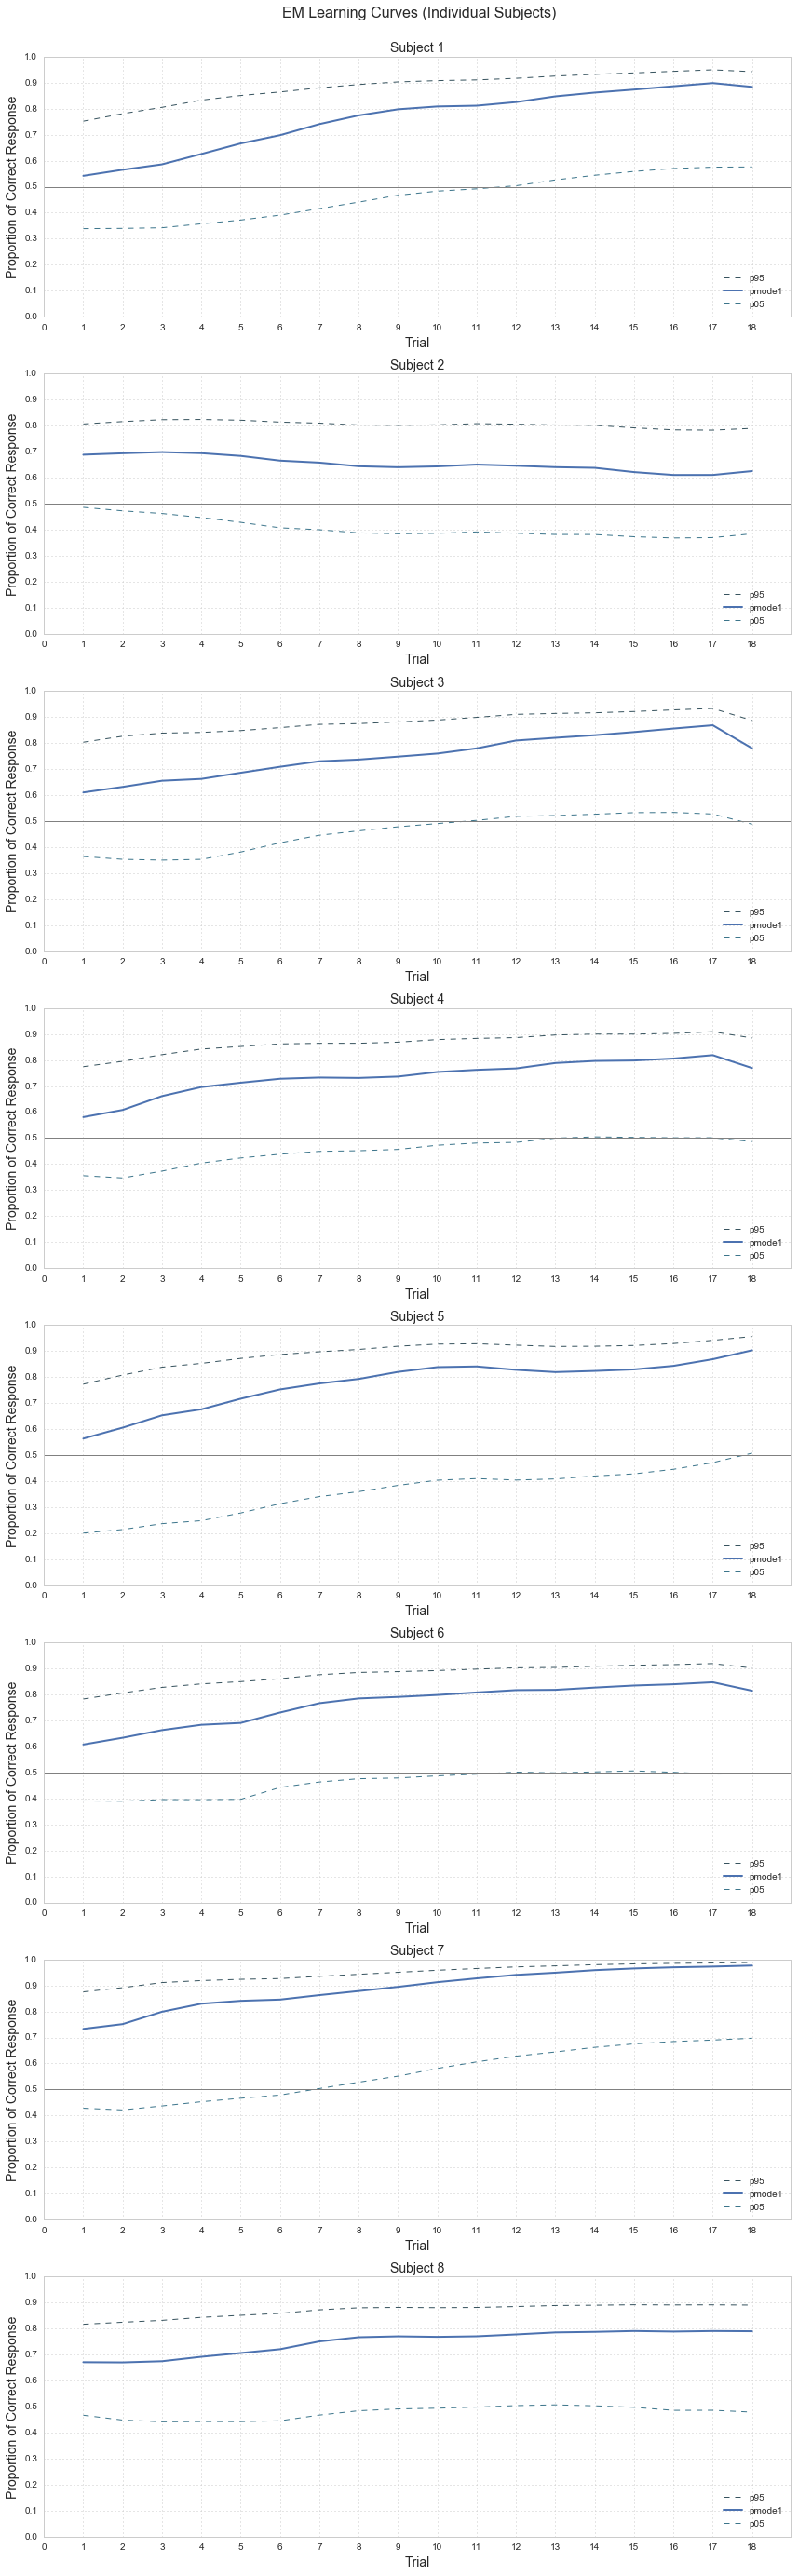

In [80]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(len(em_average), figsize=(12,38))
    for i in range(len(em_average)):
        t = range(1, len(em_average[i]['p05'])+1)
        ax[i].plot(t, em_average[i]['p95'], color=sns.color_palette("GnBu_d")[0], ls='dashed', lw='1')
        ax[i].plot(t, em_average[i]['pmode1'], lw="2")
        #ax[i].errorbar(t, em_average[i]['pmode1'], yerr=em_std[i]['pmode1'], capthick=2)
        ax[i].plot(t, em_average[i]['p05'], color=sns.color_palette("GnBu_d")[1], ls='dashed', lw='1')
        if len(em_average[i][pd.notnull(em_average[i]['cback'])]) == 0:
            cback = "N/A" 
        else:
            cback = int(em_average[i][pd.notnull(em_average[i]['cback'])]['cback'].values[0])
    #     ax[i].set_title('Subject %s with learning trial = %s' % (i+1, cback), fontsize=14)
        ax[i].set_title('Subject %s' % (i+1), fontsize=14)
        ax[i].set_xlabel('Trial', fontsize=14)
        ax[i].set_ylabel('Proportion of Correct Response', fontsize=14)
        ax[i].set_ylim(0, 1)
        ax[i].set_yticks(np.arange(0, 1.1, 0.1))
        ax[i].set_xlim(0, len(em_average[i])+1)
        ax[i].set_xticks(np.arange(0, len(em_average[i])+1, 1))
        ax[i].axhline(y=0.5, color="gray", lw="1")
        fig.suptitle('EM Learning Curves (Individual Subjects)', y=1.01, x=0.525, fontsize=16)
        plt.tight_layout()
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles, labels, loc=4)
        ax[i].grid(linestyle='dotted')
    fig.savefig('EM Learning Curves (Individual Subjects)', dpi=300)

In [ ]:
fm_list[0]

## Machine Learning - Linear Regression

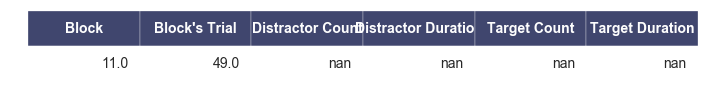

In [24]:
from matplotlib.externals import six
df = matrix.head(10)
def render_mpl_table(df, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(df, header_columns=0, col_width=2.0)

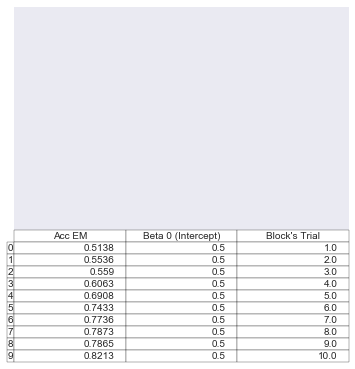

In [18]:
from pandas.tools.plotting import table

ax = plt.subplot(111) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, matrix.head(10))  # where df is your data frame

plt.savefig('mytable.png', dpi =300)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing

### Block Trial only Predictor

In [23]:
matrix = pd.concat(fm_list, axis=0, ignore_index=False)
matrix = matrix[['Acc EM','Beta 0 (Intercept)', "Block's Trial"]]
matrix = matrix.reset_index(drop=True)
matrix.head(10)

,Acc EM,Beta 0 (Intercept),Block's Trial
0,0.5138,0.5,1.0
1,0.5536,0.5,2.0
2,0.5590,0.5,3.0
3,0.6063,0.5,4.0
4,0.6908,0.5,5.0
5,0.7433,0.5,6.0
6,0.7736,0.5,7.0
7,0.7873,0.5,8.0
8,0.7865,0.5,9.0
9,0.8213,0.5,10.0


In [26]:
y = matrix[matrix.columns[0:1]]
X = matrix[matrix.columns[1:]]
# https://stats.stackexchange.com/questions/249892/wildly-different-r2-between-statsmodels-linear-regression-and-sklearn-linear/249897
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()

In [27]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Acc EM   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     54.14
Date:                Sun, 30 Apr 2017   Prob (F-statistic):           3.13e-13
Time:                        02:20:52   Log-Likelihood:                 490.48
No. Observations:                1447   AIC:                            -977.0
Df Residuals:                    1445   BIC:                            -966.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Beta 0 (Intercept)     1.5160      0

In [ ]:
predicted = results.predict(X_test)
print "Accuracy %f" % (np.mean(predicted == np.array(y_test)))

# the actual value is within 2 sd of the predicted

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test, predicted)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

### Count only Predictors

In [28]:
matrix = pd.concat(fm_list, axis=0, ignore_index=False)
matrix = matrix.drop(['Target Duration', 'Distractor Duration', 'Block', "Block's Trial"], axis=1)
matrix = matrix.reset_index(drop=True)
matrix = matrix.fillna(0)
matrix.head(10)

,Acc EM,Acc Smoothed,Acc Smoothed Combined,Beta 0 (Intercept),Distractor Count,Target Count
0,0.5138,0.000000,0.000000,0.5,2.0,2.0
1,0.5536,0.500000,0.500000,0.5,2.0,0.0
2,0.5590,0.333333,0.000000,0.5,1.0,2.0
3,0.6063,0.250000,0.333333,0.5,2.0,1.0
4,0.6908,0.400000,0.500000,0.5,1.0,0.0
5,0.7433,0.600000,0.500000,0.5,2.0,4.0
6,0.7736,0.600000,0.666667,0.5,3.0,2.0
7,0.7873,0.800000,0.750000,0.5,2.0,1.0
8,0.7865,0.800000,0.400000,0.5,3.0,0.0
9,0.8213,0.800000,0.600000,0.5,0.0,1.0


### EM Accuracy

In [29]:
y = matrix[matrix.columns[0:1]]
X = matrix[matrix.columns[3:]]
# https://stats.stackexchange.com/questions/249892/wildly-different-r2-between-statsmodels-linear-regression-and-sklearn-linear/249897
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Acc EM   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     77.35
Date:                Sun, 30 Apr 2017   Prob (F-statistic):           1.22e-32
Time:                        02:25:11   Log-Likelihood:                 537.51
No. Observations:                1447   AIC:                            -1069.
Df Residuals:                    1444   BIC:                            -1053.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Beta 0 (Intercept)     1.6593      0

In [ ]:
predicted = results.predict(X_test)
print "Accuracy %f" % (np.mean(predicted == np.array(y_test)))
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test, predicted)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

### Smooth Accuracy

In [ ]:
y = matrix[matrix.columns[1:2]]
X = matrix[matrix.columns[3:]]
# https://stats.stackexchange.com/questions/249892/wildly-different-r2-between-statsmodels-linear-regression-and-sklearn-linear/249897
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
predicted = results.predict(X_test)
print "Accuracy %f" % (np.mean(predicted == np.array(y_test)))
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test, predicted)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

### Combined Smooth Acc

In [ ]:
y = matrix[matrix.columns[2:3]]
X = matrix[matrix.columns[3:]]
# https://stats.stackexchange.com/questions/249892/wildly-different-r2-between-statsmodels-linear-regression-and-sklearn-linear/249897
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
predicted = results.predict(X_test)
print "Accuracy %f" % (np.mean(predicted == np.array(y_test)))
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test, predicted)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

### Count and Duration Predictors

In [30]:
matrix = pd.concat(fm_list, axis=0, ignore_index=False)
matrix = matrix.drop(['Block', "Block's Trial"], axis=1)
matrix = matrix.reset_index(drop=True)
matrix = matrix.dropna()
matrix.head(10)

,Acc EM,Acc Smoothed,Acc Smoothed Combined,Beta 0 (Intercept),Distractor Count,Distractor Duration,Target Count,Target Duration
0,0.5138,0.000000,0.000000,0.5,2.0,0.349836,2.0,0.135036
2,0.5590,0.333333,0.000000,0.5,1.0,0.196646,2.0,0.204968
3,0.6063,0.250000,0.333333,0.5,2.0,0.208260,1.0,0.159977
5,0.7433,0.600000,0.500000,0.5,2.0,0.104936,4.0,0.229158
6,0.7736,0.600000,0.666667,0.5,3.0,0.194450,2.0,0.203300
7,0.7873,0.800000,0.750000,0.5,2.0,0.198316,1.0,0.273279
13,0.8891,0.800000,0.600000,0.5,5.0,0.305970,2.0,0.179975
16,0.9406,0.800000,0.600000,0.5,2.0,0.073323,2.0,0.316674
17,0.9506,1.000000,1.000000,0.5,1.0,0.319940,1.0,0.459933
20,0.9719,1.000000,0.800000,0.5,1.0,0.459923,1.0,0.319963


### EM Acc

In [ ]:
cor_X.head(1)

In [ ]:
cor_X.corr?

In [79]:
scipy.stats.pearsonr(cor_X['Target Count'], cor_X['Target Duration'])

(-0.052972972310689335, 0.062527406376950326)

In [78]:
scipy.stats.pearsonr(cor_X['Distractor Duration'], cor_X['Target Duration'])

(0.082082771208224409, 0.0038660261328538597)

In [77]:
scipy.stats.pearsonr(cor_X['Distractor Duration'], cor_X['Target Count'])

(0.061774448667541844, 0.029814324318487333)

In [75]:
scipy.stats.pearsonr(cor_X['Distractor Count'], cor_X['Target Count'])

(0.71795860664734468, 1.5421093293162181e-196)

In [74]:
scipy.stats.pearsonr(cor_X['Distractor Count'], cor_X['Target Duration'])

(-0.014165185872125183, 0.6186777424327059)

In [76]:
scipy.stats.pearsonr(cor_X['Distractor Count'], cor_X['Distractor Duration'])

(0.083010681634324388, 0.0034816963100198751)

In [66]:
import scipy as scipy
scipy.stats.pearsonr(cor_X['Acc EM'], cor_X['Target Count'])

(-0.1213900411099814, 1.8611053694586777e-05)

In [67]:
scipy.stats.pearsonr(cor_X['Acc EM'], cor_X['Target Duration'])

(-0.031188775629472105, 0.27303570254187587)

In [70]:
scipy.stats.pearsonr(cor_X['Acc EM'], cor_X['Distractor Count'])

(-0.26805853353724018, 8.4339734136674586e-22)

In [68]:
scipy.stats.pearsonr(cor_X['Acc EM'], cor_X['Distractor Duration'])

(-0.17965022473055067, 1.9664905467105042e-10)

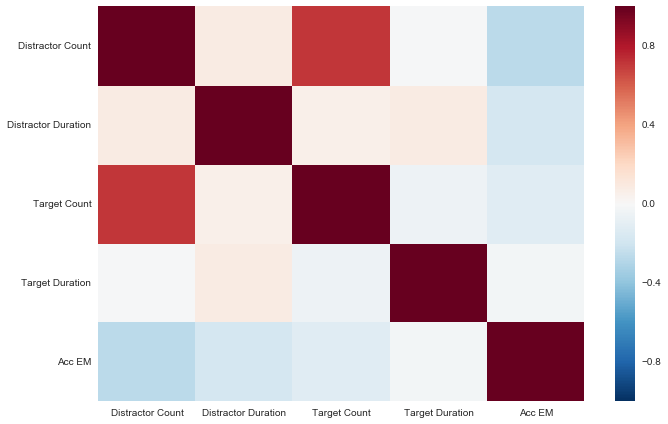

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cor_X.corr())
plt.tight_layout()
plt.savefig('Heat Map of Correlation Matrix.png', dpi=300)

In [71]:
cor_X.corr()

,Distractor Count,Distractor Duration,Target Count,Target Duration,Acc EM
Distractor Count,1.000000,0.083011,0.717959,-0.014165,-0.268059
Distractor Duration,0.083011,1.000000,0.061774,0.082083,-0.179650
Target Count,0.717959,0.061774,1.000000,-0.052973,-0.121390
Target Duration,-0.014165,0.082083,-0.052973,1.000000,-0.031189
Acc EM,-0.268059,-0.179650,-0.121390,-0.031189,1.000000


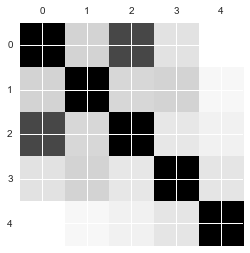

In [53]:
cor_X = X[X.columns[1:]]
cor_X['Acc EM'] = y

plt.matshow(cor_X.corr())

In [31]:
y = matrix[matrix.columns[0:1]]
X = matrix[matrix.columns[3:]]
# https://stats.stackexchange.com/questions/249892/wildly-different-r2-between-statsmodels-linear-regression-and-sklearn-linear/249897
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Acc EM   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     29.18
Date:                Sun, 30 Apr 2017   Prob (F-statistic):           5.98e-23
Time:                        02:25:22   Log-Likelihood:                 361.04
No. Observations:                 989   AIC:                            -712.1
Df Residuals:                     984   BIC:                            -687.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Beta 0 (Intercept)      1.7455    

In [ ]:
predicted = results.predict(X_test)
print "Accuracy %f" % (np.mean(predicted == np.array(y_test)))
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test, predicted)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

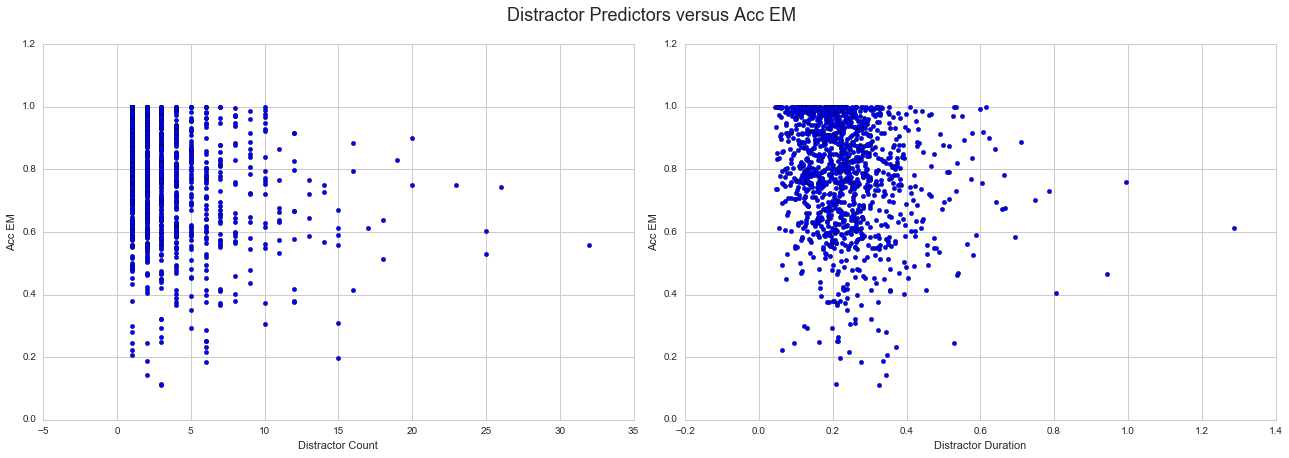

In [49]:
with sns.axes_style('whitegrid'):
    row = 1
    col = 2
    k = 1
    fig, ax = plt.subplots(ncols=col, figsize=(18, 6))
    fig.suptitle("Distractor Predictors versus Acc EM", fontsize=18, y=1.05, x=0.505)
    for j in range(col):
        ax[j].scatter(matrix[X.columns[k]], matrix[y.columns[0]])
        ax[j].set_xlabel(X.columns[k])
        ax[j].set_ylabel(y.columns[0])
        k = k + 1
    fig.tight_layout()
    fig.savefig('Distractor Predictor vs Acc EM.png', dpi=300)

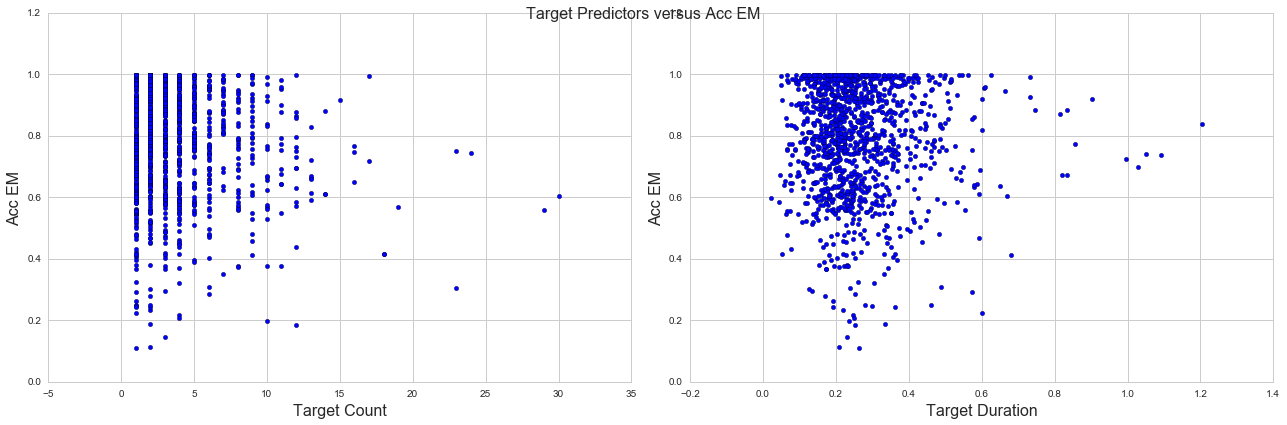

In [52]:
with sns.axes_style('whitegrid'):
    row = 1
    col = 2
    k = 3
    fig, ax = plt.subplots(ncols=col, figsize=(18, 6))
    fig.suptitle("Target Predictors versus Acc EM", fontsize=16)
    for j in range(col):
        ax[j].scatter(matrix[X.columns[k]], matrix[y.columns[0]])
        ax[j].set_xlabel(X.columns[k], fontsize=16)
        ax[j].set_ylabel(y.columns[0], fontsize=16)
        k = k + 1
    fig.tight_layout()
    fig.savefig('Target Predictors vs Acc EM.png', dpi=300)

### Smooth Acc

In [ ]:
y = matrix[matrix.columns[1:2]]
X = matrix[matrix.columns[3:]]
# https://stats.stackexchange.com/questions/249892/wildly-different-r2-between-statsmodels-linear-regression-and-sklearn-linear/249897
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
## Smoothed Accuracy
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
predicted = results.predict(X_test)
print "Accuracy %f" % (np.mean(predicted == np.array(y_test)))
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test, predicted)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

### Combined Smooth Acc

In [ ]:
y = matrix[matrix.columns[2:3]]
X = matrix[matrix.columns[3:]]
# https://stats.stackexchange.com/questions/249892/wildly-different-r2-between-statsmodels-linear-regression-and-sklearn-linear/249897
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
## Combined Smoothed Accuracy
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
predicted = results.predict(X_test)
print "Accuracy %f" % (np.mean(predicted == np.array(y_test)))
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test, predicted)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

### Normalizing only predictors

In [ ]:
matrix = pd.concat(fm_list, axis=0, ignore_index=False)
matrix = matrix.drop(['Block', "Block's Trial", 'Beta 0 (Intercept)'], axis=1)
matrix = matrix.reset_index(drop=True)

In [ ]:
normalized_df

In [ ]:
preprocessing.normalize?

In [ ]:
normalized_matrix = preprocessing.normalize(matrix[matrix.columns[3:]])
normalized_df = pd.DataFrame(normalized_matrix, columns = matrix[matrix.columns[3:]].columns)
normalized_df['Beta 0 (Intercept)'] = [0.5] * len(normalized_df)

normalized_df = normalized_df.reindex_axis(sorted(normalized_df.columns), axis=1)
X = normalized_df
y = matrix[matrix.columns[0:1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
with sns.axes_style('whitegrid'):
    row = 2
    col = 2
    k = 1
    fig, ax = plt.subplots(row, col, figsize=(15, 8))
    fig.suptitle('Normalized Predictors vs Accuracy EM', fontsize=18)
    for i in range(row):
        for j in range(col):
            ax[i][j].scatter(X[X.columns[k]], y)
            ax[i][j].set_xlabel(X.columns[k])
            ax[i][j].set_ylabel(y.columns[0])
            k = k + 1

### Normalizing everything

In [ ]:
normalized_matrix = preprocessing.normalize(matrix)
normalized_df = pd.DataFrame(normalized_matrix, columns = matrix.columns)
normalized_df['Beta 0 (Intercept)'] = [0.5] * len(normalized_df)

normalized_df = normalized_df.reindex_axis(sorted(normalized_df.columns), axis=1)

X = normalized_df[normalized_df.columns[3:]]
y = normalized_df[normalized_df.columns[0:1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
with sns.axes_style('whitegrid'):
    row = 2
    col = 2
    k = 1
    fig, ax = plt.subplots(row, col, figsize=(15, 8))
    fig.suptitle('Normalized Predictors vs Accuracy EM', fontsize=18)
    for i in range(row):
        for j in range(col):
            ax[i][j].scatter(X[X.columns[k]], y)
            ax[i][j].set_xlabel(X.columns[k])
            ax[i][j].set_ylabel(y.columns[0])
            k = k + 1

### Scaling just predictors

In [ ]:
scaled_matrix = preprocessing.scale(matrix[matrix.columns[3:]])
scaled_df = pd.DataFrame(scaled_matrix, columns = matrix[matrix.columns[3:]].columns)
scaled_df['Beta 0 (Intercept)'] = [0.5] * len(scaled_df)

scaled_df = scaled_df.reindex_axis(sorted(scaled_df.columns), axis=1)

X = scaled_df
y = matrix[matrix.columns[0:1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
with sns.axes_style('whitegrid'):
    row = 2
    col = 2
    k = 1
    fig, ax = plt.subplots(row, col, figsize=(15, 8))
    fig.suptitle('Standardized Predictors vs Acc EM', fontsize=18)
    for i in range(row):
        for j in range(col):
            ax[i][j].scatter(X[X.columns[k]], y)
            ax[i][j].set_xlabel(X.columns[k])
            ax[i][j].set_ylabel(y.columns[0])
            k = k + 1

### Scaling everything

In [ ]:
scaled_matrix = preprocessing.scale(matrix)
scaled_df = pd.DataFrame(scaled_matrix, columns = matrix.columns)
scaled_df['Beta 0 (Intercept)'] = [0.5] * len(scaled_df)

scaled_df = scaled_df.reindex_axis(sorted(scaled_df.columns), axis=1)

X = scaled_df[scaled_df.columns[3:]]
y = scaled_df[scaled_df.columns[0:1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
with sns.axes_style('whitegrid'):
    row = 2
    col = 2
    k = 1
    fig, ax = plt.subplots(row, col, figsize=(15, 8))
    fig.suptitle('Standardized Predictors vs Acc EM', fontsize=18)
    for i in range(row):
        for j in range(col):
            ax[i][j].scatter(X[X.columns[k]], y)
            ax[i][j].set_xlabel(X.columns[k])
            ax[i][j].set_ylabel(y.columns[0])
            k = k + 1

### Coefficients of Predictors

In [ ]:
mean = []
for i in range(len(results.params)):
    mean.append((results.params.index[i], results.params[i]))
mean_df = pd.DataFrame(mean, columns=['Feature Type', 'Coefficient Value'])

results_list = []
d = []
for i in fm_list:
    X = i[i.columns[1:]]
    y = i[i.columns[0:1]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model = sm.OLS(y_test, X_test)
    results = model.fit()
    #print(results.params)
    results_list.append(results.params)
for i in results_list:
    for j in range(len(i)):
        d.append((i.index[j], i[j]))
d_df = pd.DataFrame(d, columns=['Feature Type', 'Coefficient Value'])

flatui = ["yellow", "yellow", 'yellow', "yellow"]
sns.color_palette(flatui)
fig = plt.figure(figsize=(20, 8))
sns.stripplot(x="Feature Type", y="Coefficient Value", data=d_df, size=12, marker='o', split=True,linewidth=2,edgecolor="gray")
sns.stripplot(x="Feature Type", y="Coefficient Value", data=mean_df, size=15, palette=sns.color_palette(flatui), split=True,linewidth=2,edgecolor="gray", marker='*')

In [ ]:
# https://stats.stackexchange.com/questions/146804/difference-between-statsmodel-ols-and-scikit-linear-regression
predictions = results.predict(X_test)

In [ ]:
# compare in
lr = LinearRegression()
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=359)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Scikit Learn's Linear Regression (With Intercept)

In [ ]:
lr = LinearRegression(fit_intercept=True)
print str(lr) + "\n"
lr.fit(X_train, y_train)
print "Linear Regression Score: %f" % (lr.score(X_test, y_test))
print "Linear Regression Coefficients: %s" % (lr.coef_)